In [1]:
import pandas as pd
import matplotlib.pyplot as plt

/Users/Tochi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('tables/carsized_data_edit.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312 entries, 0 to 2311
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   url                  2312 non-null   object 
 1   manufacturer         2312 non-null   object 
 2   car_name             2312 non-null   object 
 3   body_style           2312 non-null   object 
 4   production_start     2312 non-null   int64  
 5   production_end       1710 non-null   float64
 6   length               2312 non-null   float64
 7   width                2312 non-null   float64
 8   width_incl_mirrors   1366 non-null   float64
 9   height               2312 non-null   float64
 10  wheelbase            2312 non-null   float64
 11  ground_clearance     1566 non-null   float64
 12  cargo_volume_eu      1904 non-null   float64
 13  cargo_volume_us      0 non-null      float64
 14  cargo_volume_max_eu  1359 non-null   float64
 15  cargo_volume_max_us  0 non-null      f

In [3]:
# Drop US cargo volume columns and rename EU columns
df = df.drop(columns=['cargo_volume_us', 'cargo_volume_max_us'])
df = df.rename(columns={
    'cargo_volume_eu': 'cargo_volume',
    'cargo_volume_max_eu': 'cargo_volume_max'
})

In [4]:
def get_body_style_general(body_style):
    """Map detailed body_style to general category.
    
    Rules (in priority order):
    1. Contains 'van' (but not 'minivan') - Minivan
    2. Contains 'minivan' - Minivan
    3. Contains 'pick-up' - Pick-up
    4. Contains 'phaeton' - Cabriolet
    5. Contains 'offroader' - SUV
    6. Contains 'targa' - Cabriolet
    7. Contains 'microcar' - Hatchback
    8. Contains 'fastback sedan' - Sedan
    9. Contains 'fastback' - Hatchback
    10. Contains 'crossover' or ends with 'cross' - Crossover
    11. Contains 'roadster', 'speedster', or 'semi-cabriolet' - Cabriolet
    12. Default: last word matching a general category
    """
    if pd.isna(body_style):
        return None
    
    bs = str(body_style).lower()
    
    # Exception rules (priority order)
    if 'van' in bs and 'minivan' not in bs:
        return 'Minivan'
    if 'minivan' in bs:
        return 'Minivan'
    if 'pick-up' in bs:
        return 'Pick-up'
    if 'phaeton' in bs:
        return 'Cabriolet'
    if 'offroader' in bs:
        return 'SUV'
    if 'targa' in bs:
        return 'Cabriolet'
    if 'microcar' in bs:
        return 'Hatchback'
    if 'fastback sedan' in bs:
        return 'Sedan'
    if 'fastback' in bs:
        return 'Hatchback'
    if 'crossover' in bs or bs.endswith('cross'):
        return 'Crossover'
    if 'roadster' in bs or 'speedster' in bs or 'semi-cabriolet' in bs:
        return 'Cabriolet'
    
    # General rule: last word matching a category
    categories = {
        'hatchback': 'Hatchback',
        'cabriolet': 'Cabriolet',
        'suv': 'SUV',
        'coupé': 'Coupé',
        'coupe': 'Coupé',
        'sedan': 'Sedan',
        'liftback': 'Liftback',
        'estate': 'Estate',
    }
    
    words = bs.replace('-', ' ').split()
    for word in reversed(words):
        if word in categories:
            return categories[word]
    
    # Fallback: any category in string
    for key, val in categories.items():
        if key in bs:
            return val
    
    return None

df['body_style_general'] = df['body_style'].apply(get_body_style_general)

# Reorder columns
cols = df.columns.tolist()
cols.remove('body_style_general')
idx = cols.index('body_style')
cols.insert(idx, 'body_style_general')
df = df[cols]
df.head()

,url,manufacturer,car_name,body_style_general,body_style,production_start,production_end,length,width,width_incl_mirrors,height,wheelbase,ground_clearance,cargo_volume,cargo_volume_max,weight,segment,price_eu,price_us
0,https://www.carsized.com/en/cars/abarth-500-20...,Abarth,500,Hatchback,3-door Hatchback,2008,2016.0,365.7,162.7,189.3,148.5,230.0,10.4,185.0,610.0,1110.0,Standard,17850.0,NaN
1,https://www.carsized.com/en/cars/abarth-500-20...,Abarth,500,Hatchback,3-door Hatchback,2016,2022.0,366.0,162.7,189.3,148.5,230.0,10.4,185.0,610.0,1110.0,Standard,18490.0,NaN
2,https://www.carsized.com/en/cars/abarth-500-20...,Abarth,500e,Cabriolet,Semi-cabriolet,2022,NaN,367.3,168.2,190.0,151.8,232.2,NaN,185.0,550.0,1435.0,Standard,40990.0,NaN
3,https://www.carsized.com/en/cars/abarth-punto-...,Abarth,Punto,Hatchback,3-door Hatchback,2008,2010.0,404.1,172.6,NaN,149.0,251.0,NaN,275.0,1030.0,1260.0,Standard,18500.0,NaN
4,https://www.carsized.com/en/cars/acura-integra...,Acura,Integra,Liftback,Liftback,2022,NaN,471.9,182.9,NaN,141.0,273.6,13.0,NaN,NaN,1399.0,Premium,NaN,31300.0


In [5]:
# Rename specific car models
# Lynk & Co '1' -> '01', Zeekr '1' -> '001'
df.loc[(df['manufacturer'] == 'Lynk & Co') & (df['car_name'] == '1'), 'car_name'] = '01'
df.loc[(df['manufacturer'] == 'Zeekr') & (df['car_name'] == '1'), 'car_name'] = '001'

In [6]:
# Create half_decade based on production_start (5-year bins starting at 0)
def get_half_decade(year):
    start = (year // 5) * 5
    end = start + 4
    return f'{start}-{end}'

df['half_decade'] = df['production_start'].apply(get_half_decade)

# Create decade based on production_start (10-year bins)
def get_decade(year):
    start = (year // 10) * 10
    return f'{start}s'

df['decade'] = df['production_start'].apply(get_decade)

# Reorder columns to place half_decade and decade after production_end
cols = df.columns.tolist()
cols.remove('half_decade')
cols.remove('decade')
idx = cols.index('production_end') + 1
cols.insert(idx, 'half_decade')
cols.insert(idx + 1, 'decade')
df = df[cols]

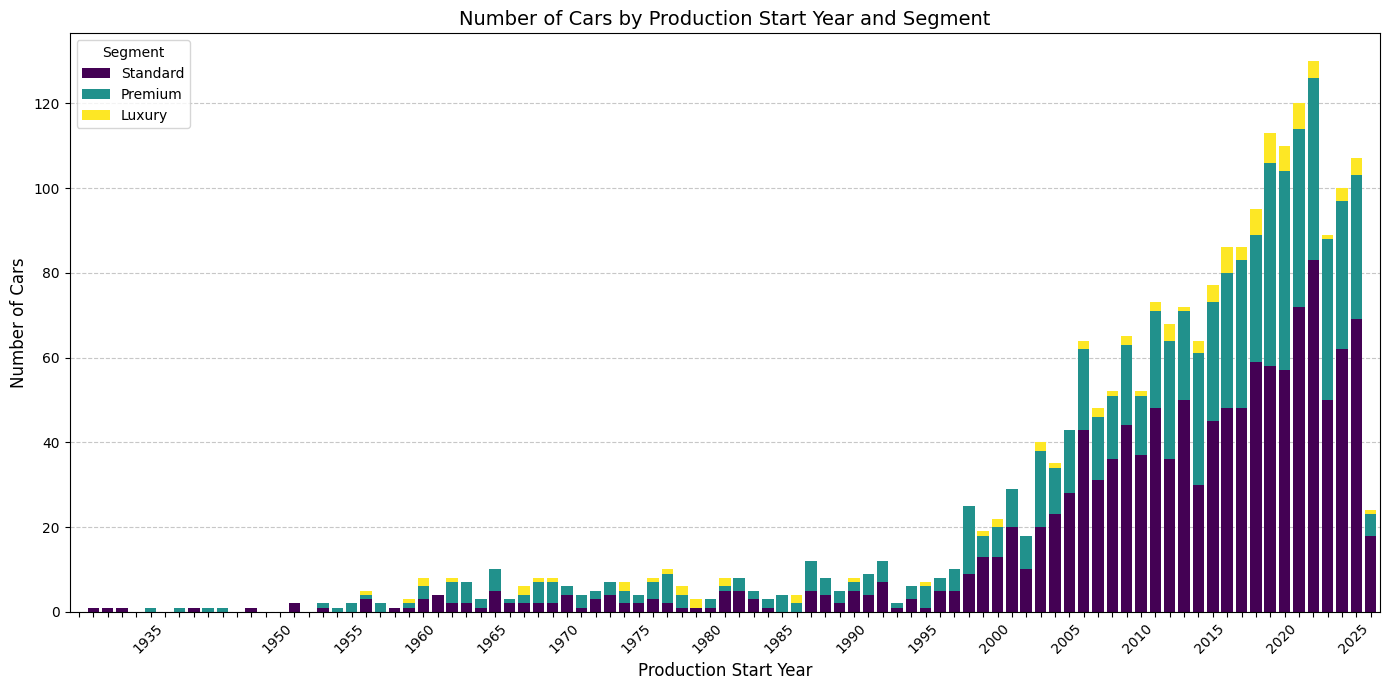

In [7]:
# Create a pivot table: count of cars by production_start year and segment
pivot_data = df.groupby(['production_start', 'segment']).size().unstack(fill_value=0)

# Reorder columns for better visualization (Standard, Premium, Luxury)
segment_order = ['Standard', 'Premium', 'Luxury']
pivot_data = pivot_data[[col for col in segment_order if col in pivot_data.columns]]

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

pivot_data.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', width=0.8)

ax.set_xlabel('Production Start Year', fontsize=12)
ax.set_ylabel('Number of Cars', fontsize=12)
ax.set_title('Number of Cars by Production Start Year and Segment', fontsize=14)
ax.legend(title='Segment', loc='upper left')

# Show x-axis labels every 5 years
tick_positions = range(len(pivot_data.index))
tick_labels = [str(year) if year % 5 == 0 else '' for year in pivot_data.index]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

# Add gridlines for easier reading
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

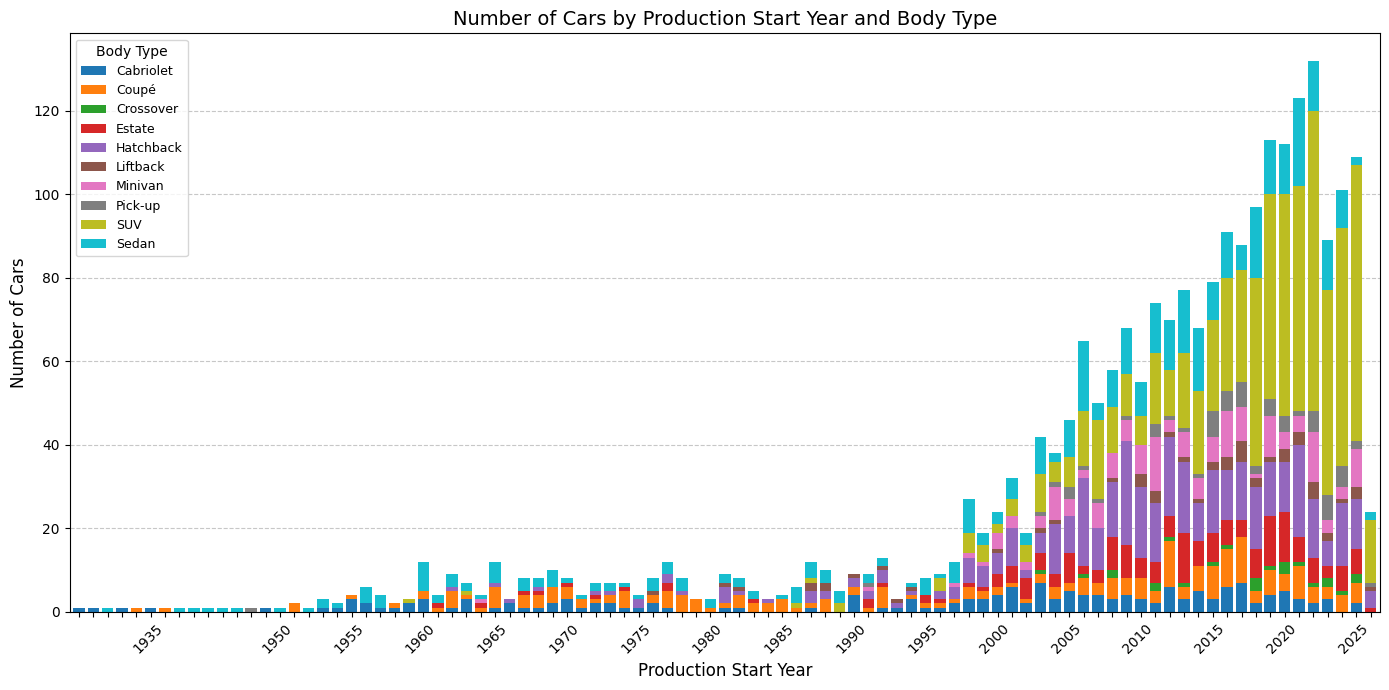

In [8]:
# Create a pivot table: count of cars by production_start year and body_style_general
pivot_body = df.groupby(['production_start', 'body_style_general']).size().unstack(fill_value=0)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

pivot_body.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)

ax.set_xlabel('Production Start Year', fontsize=12)
ax.set_ylabel('Number of Cars', fontsize=12)
ax.set_title('Number of Cars by Production Start Year and Body Type', fontsize=14)
ax.legend(title='Body Type', loc='upper left', fontsize=9)

# Show x-axis labels every 5 years
tick_positions = range(len(pivot_body.index))
tick_labels = [str(year) if year % 5 == 0 else '' for year in pivot_body.index]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

# Add gridlines for easier reading
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

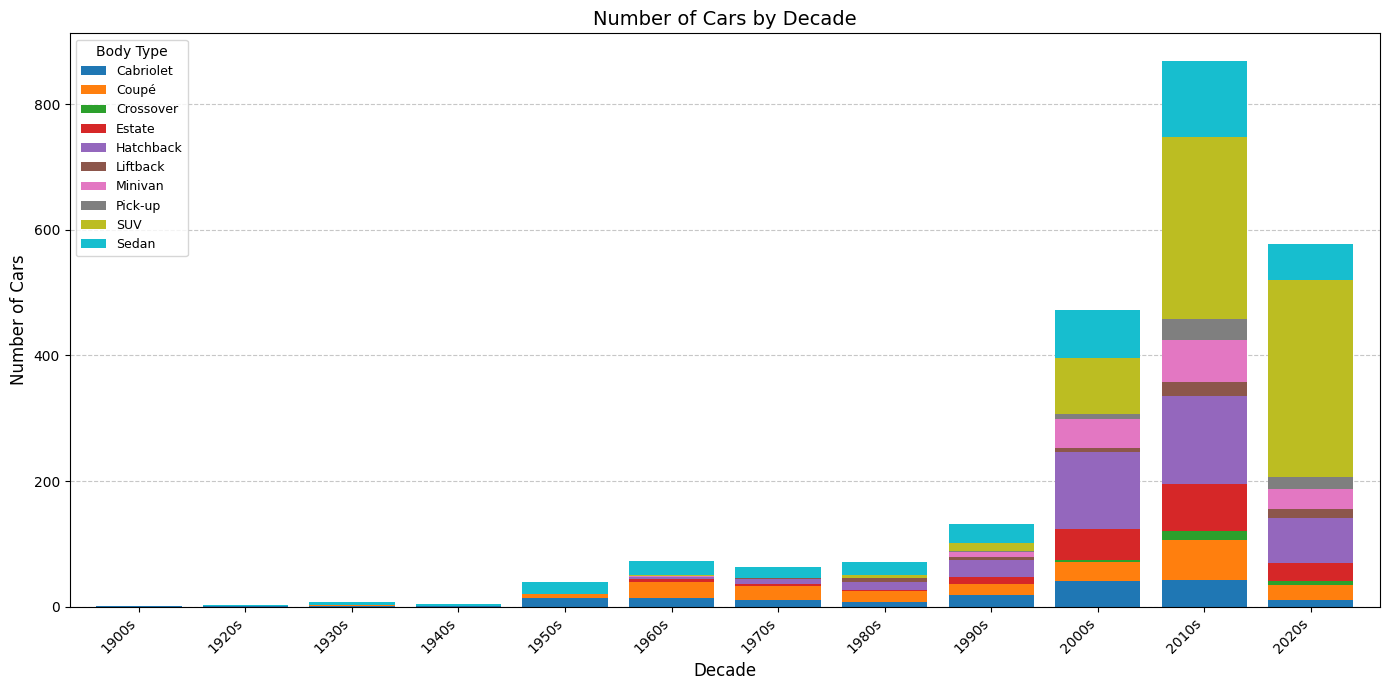

In [9]:
# Create a pivot table: count of cars by decade and body_style_general
pivot_decade = df.groupby(['decade', 'body_style_general']).size().unstack(fill_value=0)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

pivot_decade.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)

ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Number of Cars', fontsize=12)
ax.set_title('Number of Cars by Decade', fontsize=14)
ax.legend(title='Body Type', loc='upper left', fontsize=9)

# Rotate x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add gridlines for easier reading
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [10]:
# Create pivot table showing count and share by decade
decade_counts = df.groupby('decade').size().reset_index(name='count')
decade_counts['share'] = (decade_counts['count'] / decade_counts['count'].sum() * 100).round(2)
decade_counts['share'] = decade_counts['share'].astype(str) + '%'
decade_counts

,decade,count,share
0,1900s,1,0.04%
1,1920s,3,0.13%
2,1930s,7,0.3%
3,1940s,4,0.17%
4,1950s,39,1.69%
5,1960s,73,3.16%
6,1970s,63,2.72%
7,1980s,71,3.07%
8,1990s,131,5.67%
9,2000s,473,20.46%


In [11]:
# Rename '--' segment to 'Uncategorized'
df['segment'] = df['segment'].replace('--', 'Uncategorized')

In [12]:
# Create additional columns for Streamlit apps and export clean dataset

# production_end_display: show year or "present" if NaN
df['production_end_display'] = df['production_end'].apply(
    lambda x: 'present' if pd.isna(x) else str(int(x))
)

# car_label: formatted string for dropdown selection
df['car_label'] = df.apply(
    lambda row: f"{row['manufacturer']} {row['car_name']} ({int(row['production_start'])}-{row['production_end_display']})",
    axis=1
)

# Reorder columns to place new columns after production_end
cols = df.columns.tolist()
cols.remove('production_end_display')
cols.remove('car_label')
idx = cols.index('production_end') + 1
cols.insert(idx, 'production_end_display')
cols.insert(idx + 1, 'car_label')
df = df[cols]

# Export to carsized_data_clean.csv
df.to_csv('tables/carsized_data_clean.csv', index=False)
df.head()

,url,manufacturer,car_name,body_style_general,body_style,production_start,production_end,production_end_display,car_label,half_decade,...,width_incl_mirrors,height,wheelbase,ground_clearance,cargo_volume,cargo_volume_max,weight,segment,price_eu,price_us
0,https://www.carsized.com/en/cars/abarth-500-20...,Abarth,500,Hatchback,3-door Hatchback,2008,2016.0,2016,Abarth 500 (2008-2016),2005-2009,...,189.3,148.5,230.0,10.4,185.0,610.0,1110.0,Standard,17850.0,NaN
1,https://www.carsized.com/en/cars/abarth-500-20...,Abarth,500,Hatchback,3-door Hatchback,2016,2022.0,2022,Abarth 500 (2016-2022),2015-2019,...,189.3,148.5,230.0,10.4,185.0,610.0,1110.0,Standard,18490.0,NaN
2,https://www.carsized.com/en/cars/abarth-500-20...,Abarth,500e,Cabriolet,Semi-cabriolet,2022,NaN,present,Abarth 500e (2022-present),2020-2024,...,190.0,151.8,232.2,NaN,185.0,550.0,1435.0,Standard,40990.0,NaN
3,https://www.carsized.com/en/cars/abarth-punto-...,Abarth,Punto,Hatchback,3-door Hatchback,2008,2010.0,2010,Abarth Punto (2008-2010),2005-2009,...,NaN,149.0,251.0,NaN,275.0,1030.0,1260.0,Standard,18500.0,NaN
4,https://www.carsized.com/en/cars/acura-integra...,Acura,Integra,Liftback,Liftback,2022,NaN,present,Acura Integra (2022-present),2020-2024,...,NaN,141.0,273.6,13.0,NaN,NaN,1399.0,Premium,NaN,31300.0
